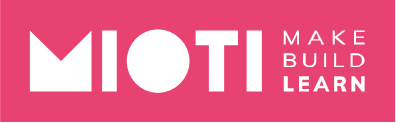
<br/>
<center style="color:#888">Master Deep Learning<br/>Asignatura Computer Vision</center>
<center style="color:#aaa; margin-top:10px;">Prof. Óscar Picazo Montoya<br>oscarpm@faculty.mioti.es</center>


# Challenge S6: Medición de distancias usando visión estéreo

## Objetivos

El objetivo de este challenge es medir distancias en profundidad utilizando técnicas de visión estéreo.



## Configuración del entorno

In [1]:
# !pip install opencv-contrib-python

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data, io, filters, img_as_ubyte
import cv2
import util_visionestereo_challenge as uvc

import warnings
warnings.filterwarnings("ignore")

### Sistema de visión estéreo

En el laboratorio se ha construido un sistema de visión estéreo y se han calibrado cada una de las cámaras por separado. Se han obtenido los parámetros intrínsecos para la cámara izquierda y derecha (`mtx_left`, `mtx_right`), las distorsiones de cada una de ellas (`dist_left`, `dist_right`) y nos proporcionan también las coordenadas reales del patrón ajedrezado que han usado en la calibración `objpoints` así como las coordenadas en <i>x</i> e <i>y</i> de ese patrón en cada una de las imágenes usadas para calibrarlas (`imgpointsL`, `imgpointsR`).

Todos estos valores nos los han pasado comprimidos en un fichero <i>NPZ</i> de numpy llamado `calibrated.npz` en el mismo directorio del challenge:

In [3]:
npzfile = np.load("calibrated.npz")

objpoints = npzfile['objpoints']
imgpointsL = npzfile['imgpointsL']
imgpointsR = npzfile['imgpointsR']
mtx_left = npzfile['mtx_left']
mtx_right = npzfile['mtx_right']
dist_left = npzfile['dist_left']
dist_right = npzfile['dist_right']

Adicionalmente a este fichero nos proporcionan dos capturas `test1` y `test2`, con la imagen obtenida de la cámara izquierda y derecha en cada una de las capturas y nos preguntan que validemos el sistema de visión estéreo sabiendo que el objeto que se ha colocado en las pruebas está a 85cm en el `test1` y a 105cm en el `test2`.

Estas imágenes están ubicadas en el directorio `imgs` del challenge:

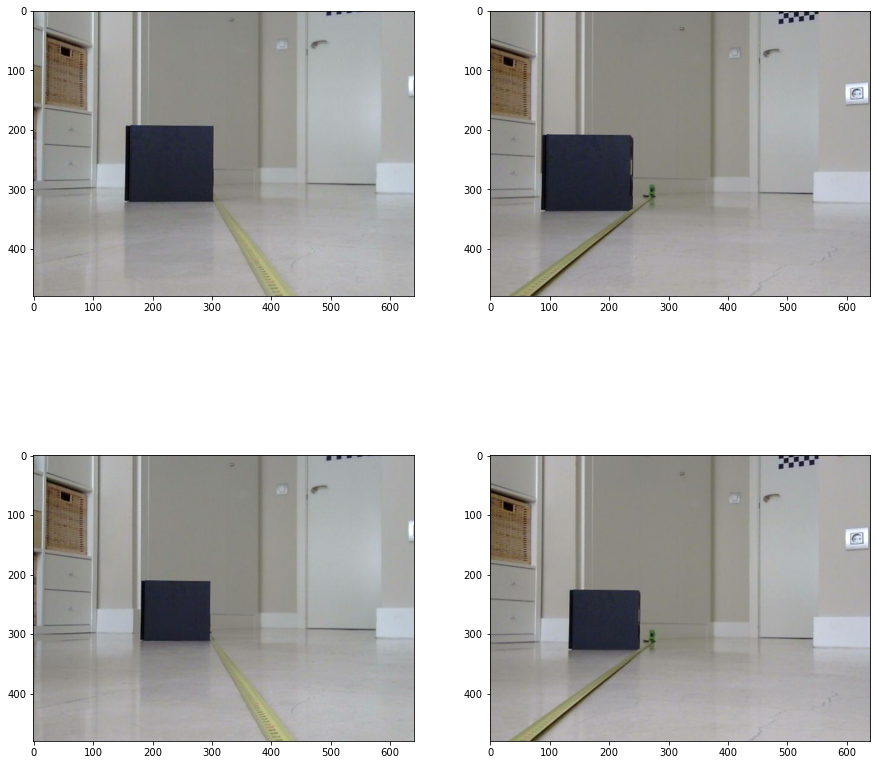

In [4]:
frameL_test1 = io.imread("imgs/img_L_test1.jpg")
frameR_test1 = io.imread("imgs/img_R_test1.jpg")

frameL_test2 = io.imread("imgs/img_L_test2.jpg")
frameR_test2 = io.imread("imgs/img_R_test2.jpg")

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,15))
ax1[0].imshow(frameL_test1)
ax1[1].imshow(frameR_test1)
ax2[0].imshow(frameL_test2)
ax2[1].imshow(frameR_test2)
io.show()


### Calibración estéreo

A partir de los datos que se disponen de las cámaras, obtén las matrices `R` y `T` necesarias para rectificar cada par de imágenes:

In [5]:
lags = 0
flags = cv2.CALIB_FIX_INTRINSIC # INDICA QUE LOS PARÉMETROS INTINSECOS Y EXTRINSECOS SE LOS DAMOS. SI NO SE LO INDICAMOS
# EL LOS CALCULA, PERO TIENE PEOR SENSIBILIDAD Y TARDA MÁS

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # 30 ES EL CRITERIO DE PARADA

retS, MLS, dLS, MRS, dRS, R, T, E, F= cv2.stereoCalibrate(objpoints,
                                                          imgpointsL,
                                                          imgpointsR,
                                                          mtx_left,
                                                          dist_left,
                                                          mtx_right,
                                                          dist_right,
                                                          (640, 480),
                                                          criteria_stereo,
                                                          flags)

Calcula los mapas de rectificación `Left_Stereo_Map` y `Right_Stereo_Map`, necesarios para rectificar cualquier imagen capturada por las cámaras izquierda y derecha:

In [6]:
RL, RR, PL, PR, Q, roiL, roiR= cv2.stereoRectify(MLS, dLS, MRS, dRS,
                                                 (640,480), R, T,
                                                 0,(0,0))


Left_Stereo_Map= cv2.initUndistortRectifyMap(MLS, dLS, RL, PL,
                                             (640,480), cv2.CV_16SC2) 
Right_Stereo_Map= cv2.initUndistortRectifyMap(MRS, dRS, RR, PR,
                                              (640,480), cv2.CV_16SC2)

Crea una función que a partir de las imágenes izquierda y derecha y los mapas de rectificación, nos devuelva los mapas de disparidad de la imagen izquierda con respecto a la derecha, las imágenes izquierda y derecha rectificadas, así como los valores de disparidad.

In [7]:
def obtenerMapasDeDisparidadYValores (img_left, img_right, Left_Stereo_Map, Right_Stereo_Map):
    
    # Implementa una función que a partir de las imágenes izquierda y derecha y los mapas de rectificación, 
    # nos devuelva los mapas de disparidad de la imagen izquierda con respecto a la derecha, 
    # las imágenes izquierda y derecha rectificadas, así como los valores de disparidad.
   
    # Rectificar imágenes
    
    # Con la función remap rectificamos las imagenes
    frameLRec= cv2.remap(img_left,Left_Stereo_Map[0],Left_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)  
    frameRRec= cv2.remap(img_right,Right_Stereo_Map[0],Right_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    # Convertir a escala de grises las dos imágenes rectificadas
    grayFrameLRec= cv2.cvtColor(frameLRec,cv2.COLOR_RGB2GRAY)
    grayFrameRRec= cv2.cvtColor(frameRRec,cv2.COLOR_RGB2GRAY)
    
    
    # Crear objecto StereoSGBM
    # stereo = ...
    
    window_size = 3 # EL TAMAÑO DE LA VENTANA. EL NÚMERO ES EL NÚMERO DE PIXELS. EN ESTE CASO 3X3
    min_disp = 2
    num_disp = 128 # NÚMERO MÁXIMO DE DISPARIDADES

    # Se crea un objecto StereoSGBM es el algoritmo que nos sirve para medir la distancia
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = window_size,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        disp12MaxDiff = 5,
        P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2)

   
    # Calcular las disparidades
    disp= stereo.compute(grayFrameLRec,grayFrameRRec)
    
    # Calcular los valores normalizados de la disparidad
    disp_values = np.copy (disp)   
    disp_values = disp_values.astype(float)
    disp_values = (disp_values - min_disp) / (16.0 * num_disp)
    
    # Calcular el mapa de disparidad normalizando entre 0 y 255 para visualizar
   
    disp_norm = np.copy (disp)
    disp_norm = cv2.normalize(src=disp_norm, dst=disp_norm, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    disp_norm = np.uint8(disp_norm)
    
    # Crear objecto StereoSGBM equivalente para la cámara derecha a partir del ya creado para el de la izquierda
    stereoR=cv2.ximgproc.createRightMatcher(stereo)
    
     # Calcular las disparidades
    dispR= stereoR.compute(grayFrameRRec,grayFrameLRec)
    
    # Crear objeto para el filtro de disparidad WLS
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    
    lmbda = 80000
    sigma = 1.8

    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)


    # Aplicar el filtro
    dispFiltered = wls_filter.filter(np.int16(disp),grayFrameLRec,None,np.int16(dispR))

    # La función devuelve el mapa de disparidad normalizado entre 0 y 255 para visualizar, 
    # el mapa de disparidad mejorado con el filtro WLS, los valores de disparidad, la imagen izquierda en escala
    # de grises y la imagen derecha en escala de grises
    return disp_norm, dispFiltered, disp_values, grayFrameLRec, grayFrameRRec

Se muestran los mapas de disparidad (el normal y el mejorado), así como la imagen de la cámara izquierda rectificada:

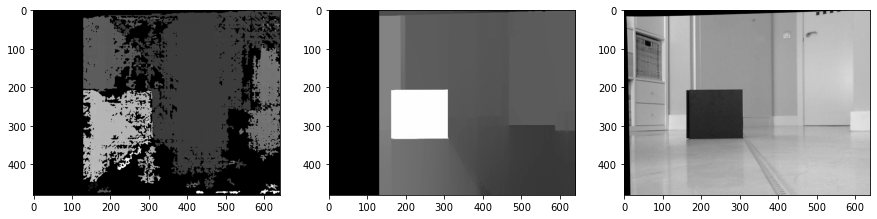

In [8]:
disp_image, disp_image_filtered, disp_values, image_L_rec, image_R_rec = obtenerMapasDeDisparidadYValores (frameL_test1, frameR_test1, Left_Stereo_Map, Right_Stereo_Map)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(disp_image, cmap=plt.cm.gray)
ax2.imshow(disp_image_filtered, cmap=plt.cm.gray)
ax3.imshow(image_L_rec, cmap=plt.cm.gray)
io.show()

A partir de los valores de disparidad `disp_values` y distintas imágenes controladas, se ha creado un modelo que nos devuelve la distancia en función de los valores de disparidad. Puedes comprobar como se ha definido este modelo en el fichero `util_visionestereo_challenge.py` que acompaña el challenge:

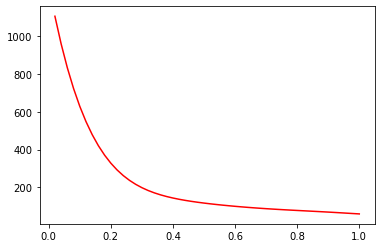

In [9]:
model = uvc.Disparidad2Distancia()
model.plot()

El siguiente problema a resolver sería aislar el objeto que queremos reconocer para obtener sus valores de disparidad. En este caso te recomiendo que utilices las técnicas de binarización sobre la imagen rectificada izquierda y uses el algoritmo de detección de blobs `label` junto con `regionprops` que ya hemos utilizado en otras sesiones.

Crea una función que a partir de una imagen, nos retorne el rectángulo de ocupación en píxeles del objeto del que queremos medir su distancia:

In [10]:
from skimage.morphology import dilation
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import disk
from skimage.util import invert

def obtenerLimitesObjeto (img_gris_rectificada):
    
    # Implementa una función que devuelva un rectángulo con las coordenadas del objeto
    
    # Binariza la imagen
    
    img_mono = img_gris_rectificada >80
    
    # Aplica un filtro de dilatación para reducir el área y evitar problemas con los límites del objeto
    
    img_mono_filtered=dilation(img_mono,disk(8))
    
    # Aplica `label` para obtener los blobs
    img_labeled = label(invert(img_mono_filtered))
    
    # Calcula las regiones de interés y devuélvelas en una variable llamada "rois"
    rois= regionprops(img_labeled)
    
    # Tendremos que encontrar cual es el roi que coincide con el objeto, te propongo este algoritmo:
    for roi in rois:
        if roi.area / roi.bbox_area > 0.85 and roi.bbox_area > 1000:
            return roi.bbox
        
    return (0,0,0,0)

Vamos a comprobar si el resultado es el correcto. Pintemos un rectángulo con las coordenadas obtenidas en la imagen donde hemos buscado el objeto y en el mapa de disparidad:

(214, 170, 327, 301)


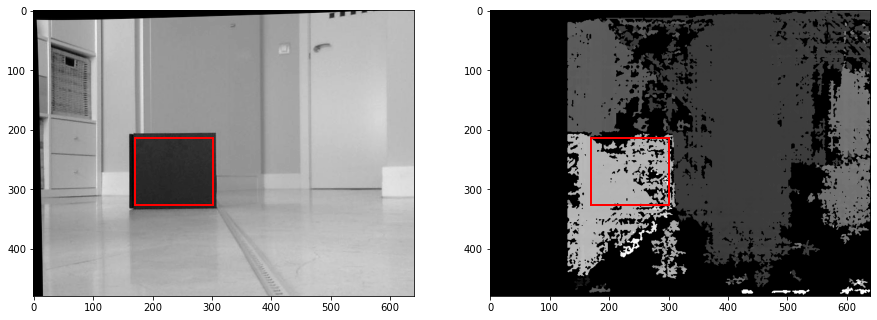

In [11]:
rect_obj = obtenerLimitesObjeto(image_L_rec)

print (rect_obj)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(image_L_rec, cmap=plt.cm.gray)
rect=mpatches.Rectangle((rect_obj[1],rect_obj[0]),rect_obj[3]-rect_obj[1],rect_obj[2]-rect_obj[0], 
                        fill = False,
                        color = "red",
                        linewidth = 2)
ax1.add_patch(rect)
ax2.imshow(disp_image, cmap=plt.cm.gray)
rect=mpatches.Rectangle((rect_obj[1],rect_obj[0]),rect_obj[3]-rect_obj[1],rect_obj[2]-rect_obj[0], 
                        fill = False,
                        color = "red",
                        linewidth = 2)
ax2.add_patch(rect)
io.show()

Veamos un histograma de los valores de las disparidades en esa región: 

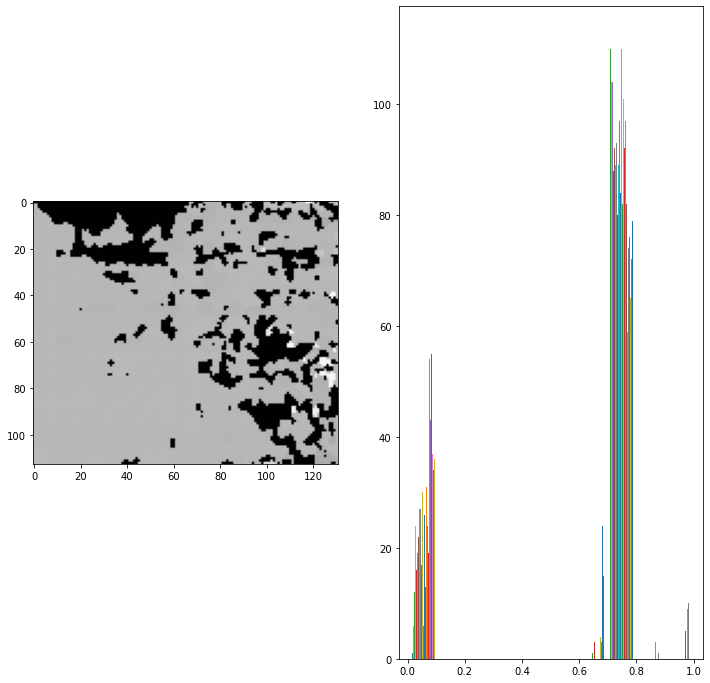

In [12]:
rango = disp_values[rect_obj[0]:rect_obj[2], rect_obj[1]:rect_obj[3]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
ax1.imshow(rango, cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
ax2.hist(rango, bins=10)
io.show()

Implementa una función que nos devuelva un valor de disparidad a partir de una matriz de disparidades. Nos interesaría buscar el valor medio entre los valores más repetidos (observa el histograma):

In [13]:
def obtenerDisparidad (disparidades):

    disparidad = 0.0
    # Implementa una función que nos devuelva el valor de disparidad entre todas las disparidades de la matriz
    return np.median(disparidades)

El valor de la distancia entre el objeto detectado y las cámaras de visión estéreo sería:

In [14]:
print ("La distancia al objeto es de: ", model.obtenerDistancia(obtenerDisparidad (rango)), "cm")

La distancia al objeto es de:  85.2095102353669 cm


Repite todo el proceso que hemos hecho para las imágenes que corresponden al `test2`, no vuelvas a definir las funciones que hemos construido, utilízalas directamente. 

Evalua el resultado de la distancia al objeto y comenta los resultados y el proceso que hemos seguido.

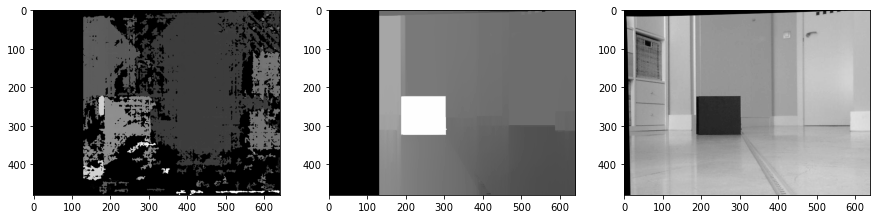

In [15]:
# Realizamos los mapas de disparidades entre las dos imagenes del test2

disp_image_2, disp_image_filtered_2,disp_values_2, image_L_rec_2, image_R_rec_2 = obtenerMapasDeDisparidadYValores (frameL_test2,
                                                                                frameR_test2,
                                                                                Left_Stereo_Map,
                                                                                Right_Stereo_Map)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(disp_image_2, cmap=plt.cm.gray)
ax2.imshow(disp_image_filtered_2, cmap=plt.cm.gray)
ax3.imshow(image_L_rec_2, cmap=plt.cm.gray)
io.show()

(232, 195, 317, 296)


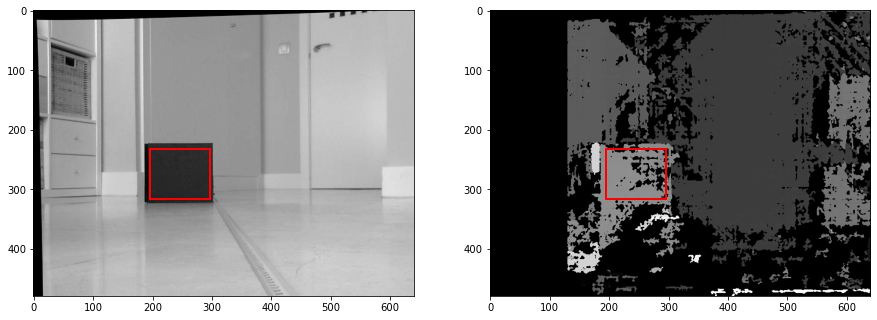

In [16]:
#Procedemos a definir donde están los rectangulos en nuestra imagen de test2

rect_obj_2 = obtenerLimitesObjeto(image_L_rec_2)

print (rect_obj_2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(image_L_rec_2, cmap=plt.cm.gray)
rect_2=mpatches.Rectangle((rect_obj_2[1],rect_obj_2[0]),rect_obj_2[3]-rect_obj_2[1],rect_obj_2[2]-rect_obj_2[0], 
                        fill = False,
                        color = "red",
                        linewidth = 2)
ax1.add_patch(rect_2)
ax2.imshow(disp_image_2, cmap=plt.cm.gray)
rect_2=mpatches.Rectangle((rect_obj_2[1],rect_obj_2[0]),rect_obj_2[3]-rect_obj_2[1],rect_obj_2[2]-rect_obj_2[0], 
                        fill = False,
                        color = "red",
                        linewidth = 2)
ax2.add_patch(rect_2)
io.show()

In [17]:
#Obtenermos una matriz de dispridades del rectangulo
rango_2 = disp_values_2[rect_obj_2[0]:rect_obj_2[2], rect_obj_2[1]:rect_obj_2[3]]

In [18]:
#Finalmente calculamos la distacia
print ("La distancia al objeto es de: ", model.obtenerDistancia(obtenerDisparidad (rango_2)), "cm")

La distancia al objeto es de:  105.51206827138958 cm


## Conclusiones

* Los resultados han sido los siguientes:
    * Para el primer par de imagenes test_1 da un resultado de **85.2095102353669 cm**
    * Para el segundo par de imagenes test_2 da un resultado de **105.51206827138958 cm**
* El proceso seguido para la obtención de estos resultados tanto de para el primer test como para el segundo han sido los siguiente:

    * Calibrado de las camaras. 
        * **Se recibe de laborartorio**:
            * los parámetros **intrínsecos** para cada uno de las cámaras.
            * las **distorsiones** de cada cámara.
            * Así como las coordenadas reales de la calibración de las imagenes del ajedrez.
            
        * **Calibrado de las camaras conjuntas**. Con eso obtenemos:
            * **El error cuadrático medio**: retS
            * **Matrices intrísecas y vectores de distortsión** de las cámaras: MLS, dLS, MRS, dRS 
            * **R, T** Matrices de proyección y traslación para situar los objetos una cámara en la otra
            * **E,F** Otras matrices.
        * **Mapas de rectificación** Necesarios para la búsqueda de equivalencias de entre una imagen de una camara en la otra. Con esto se hace que las lineas epipolares sean lineas horizontales.
        
        * **Obtención de las imagenes rectificadas y valores de disparidad** Con los mapas de rectificación anteriores, ya podemos obtener las imagenes rectificadas y los valores de disparidad. Estas imagenes rectificadas son en escala de grises.
        
        * **Calculo de distancias**.Una vez se obtienen las imagenes rectificadas ya se puden proceder a realizar el calculo de distancias. Para ello en este caso queremos calcular la distancia del cubo a las cámaras. Para ello se ha procedido a:
        
            * Calculo de blobs.
            * Cáculo de las regiones de interes, a partir de estos blobls.
            * Seleccionar la región de interes que se requiere, en esta caso basado en el tamaño del area del cuadrado.
            * Una vez se tiene esta región de interes se identifica en la matriz de valores de diaparidad.
            * Estos valores de disparidad se pasan por una fucnión que devuelve un valor de disparidad. Se aplica la mediana.
            * Por último con este valor de disparidad, y apoyandonos en la función **obtenerDistancia** de la librería **util_visionestero_challenge.py**, sacamos la distancia en cm, del cuadrado a la cámara. La función **obtenerDistancia** obtiene la distancia basandose en la predicción de un modelo, basado en una Regresión Lineal previamante entrenado, con valores de disparidad y distancias en centimetros.
            